<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-aym/GRF_notebooks/GRF_fitting_imperfect_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/My_repo/setup.py install

Mounted at /content/drive


In [312]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import purify_function,get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss,Spectra_Loss_MSE,Spectra_Loss_MAE




# Universal font size
FS = 18

# Theory

Assume that we have GRF perturbed strong lensing event. First, we want to model it without GRF perturbations and consider the residuals.

## Data

simulation: $\psi(\vec{p}_{0})+\delta \psi(A_{0},\beta_{0},\phi_{0})$  
model 1: $\psi(\vec{p_0})$  
$res_{0}=Im(\delta \psi(A_{0},\beta_{0},\phi_{0})+\psi(\vec{p}_{0})-\psi(\vec{p_1}))$

,where $\vec{p}$ is a set of source light and unperturbed lens mass parameters and $A_{0},\beta_{0},\phi_{0}$ are correpsondingly amplitude,power slope and phase realisation of GRF power spectrum. Index 0 would refer to true values or zeroth aproximation.

## Model

mock: $\psi(\vec{p}_{0})+\delta \psi(A^{i},\beta^{j},\phi_{0})$  
model 2: $\psi(\vec{p_0})$  
$res^{i,j}=Im(\delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2}))$

,where we assume that we know the exact lens-source parameters \vec{p_0}, and exact GRF phase \phi_{0}

## Loss
$ PS\{ res_{0} \}=|FFT\{res_{0}*mask\_ring\}|^{2} $  
$\mathcal{L}^{ij}=|| \ PS\{res_{0}\} - PS\{res^{i,j}\} \ ||$

## Pipeline

Given lens args $\vec{p}_{0}$ and GRF's phase $\phi_{0}$,

simulate data

logA,beta -> GRF potential -> perturbed image -> residuals with unperturbed image -> power spectrum of residuals


# Lensing setup

In [3]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

## Data grids

In [4]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [5]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [6]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [287]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

kwargs_noise={'background_rms': np.zeros((npix, npix)), 'exposure_time': np.inf}

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,kwargs_noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

perturbed_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

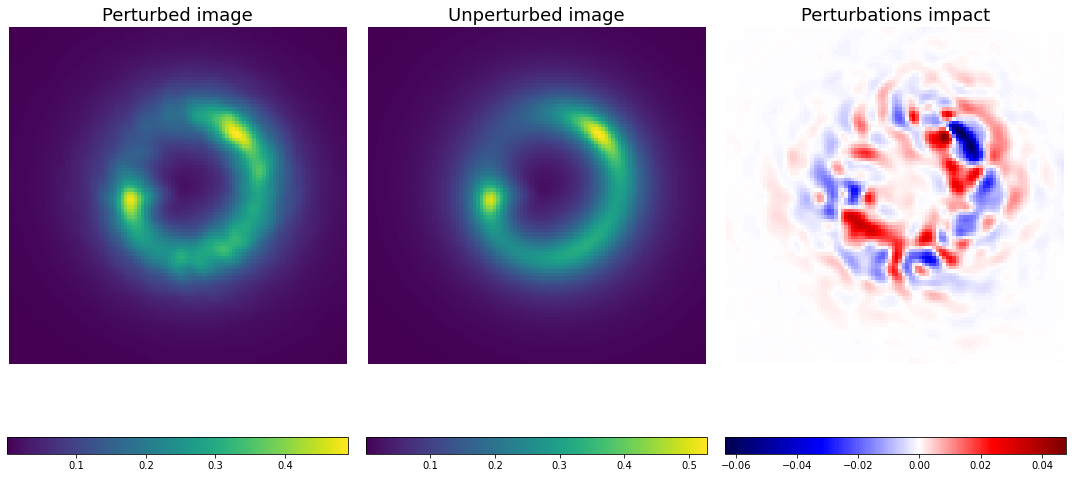

In [288]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(perturbed_image, origin='lower')
ax[0].set_title("Perturbed image", fontsize=FS)


im1=ax[1].imshow(unperturbed_image, origin='lower')
ax[1].set_title("Unperturbed image", fontsize=FS)


resid_true=perturbed_image-unperturbed_image
im2=ax[2].imshow(resid_true, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

## Einstein ring Mask

In [9]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

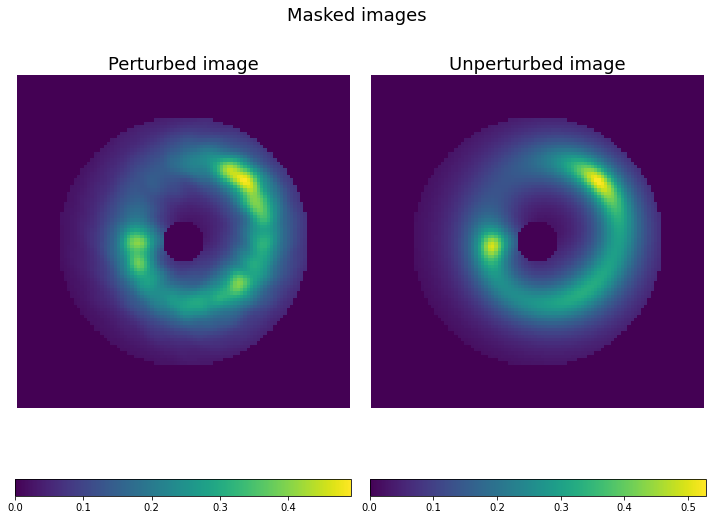

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(perturbed_image*mask, origin='lower')
ax1.set_title("Perturbed image", fontsize=FS)
img2 = ax2.imshow(unperturbed_image*mask, origin='lower')
ax2.set_title("Unperturbed image", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [11]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
@jax.partial(jax.jit,static_argnums=(1,))
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

# Target spectrum, Initial guess

In [12]:
#Compute Target Power spectrum of data residuals 
resid_true=perturbed_image-unperturbed_image
resid_true_spectrum=compute_radial_spectrum_pure(resid_true)

In [13]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,resid_true_spectrum))
GRF_init_guess=np.array(res.x)

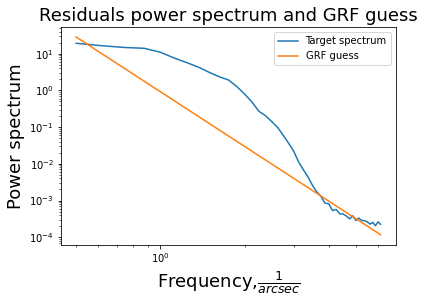

In [14]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,resid_true_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='GRF guess')
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

# GRF perfect case fitting

## MAE loss function

In [ ]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)
GRF_Loss_args=(GRF_seed,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss,*GRF_Loss_args)

In [ ]:
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

Loss: Guess=207.09, True:0.00
Grad Loss in guess: grad(logA)=0.14, grad(Beta)=-2.91


Text(0.5, 1.0, 'Log(Abs(Hessian))')

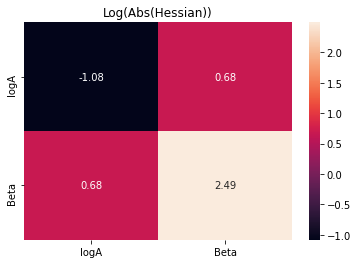

In [ ]:
print('Loss: Guess={:.2f}, True:{:.2f}'.format(loss_func(GRF_init_guess),loss_func([GRF_LogAmp,GRF_beta])))
grad_loss=grad_loss_func(GRF_init_guess)
print('Grad Loss in guess: grad(logA)={:.2f}, grad(Beta)={:.2f}'.format(grad_loss[0],grad_loss[1]))

hess_loss=hess_loss_func(GRF_init_guess)
sns.heatmap(np.log10(np.abs(hess_loss)),xticklabels=['logA','Beta'],yticklabels=['logA','Beta'],annot=True,fmt='.2f')
plt.title('Log(Abs(Hessian))')

## Loss function and Grads

In [ ]:
GRF_Amps_array=np.linspace(-7.05,-6.95,100)
GRF_Betas_array=np.linspace(1.5,2.5,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:18<00:00,  4.98s/it]


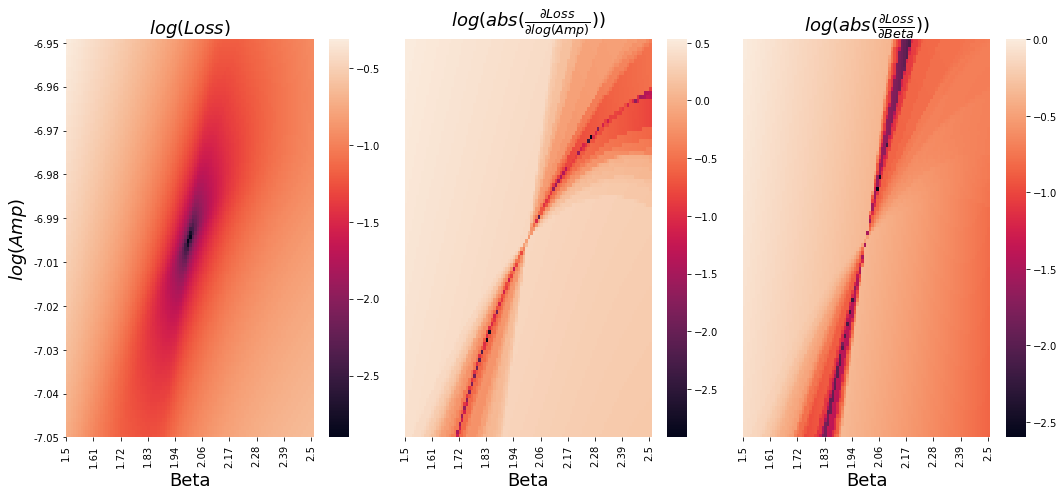

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)


im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

In [ ]:
GRF_Amps_array=np.linspace(-10.,-6.,100)
GRF_Betas_array=np.linspace(1.,8.,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:18<00:00,  4.99s/it]


In [ ]:
#Adjust history to heatmaps
def reindex_history(history):
  i_min=np.argmin(np.abs(np.nanmin(history[:,0])-GRF_Amps_array))
  j_min=np.argmin(np.abs(np.nanmin(history[:,1])-GRF_Betas_array))

  history_x_labels=j_min+(history[:,1]-np.nanmin(history[:,1]))/(GRF_Betas_array[1]-GRF_Betas_array[0])
  history_y_labels=i_min+(history[:,0]-np.nanmin(history[:,0]))/(GRF_Amps_array[1]-GRF_Amps_array[0])
  return history_x_labels,history_y_labels

In [ ]:
history_trust_constr_hess=np.load(Folder+'/Images/history_trust-constr_hess.npy',allow_pickle=True)

history_hess_x_labels,history_hess_y_labels=reindex_history(np.load(Folder+'/Images/history_trust-constr_hess.npy',allow_pickle=True))
history_jac_loose_x_labels,history_jac_loose_y_labels=reindex_history(np.load(Folder+'/Images/history_trust-constr_jac_loose_bounds.npy',allow_pickle=True))
history_jac_tight_x_labels,history_jac_tight_y_labels=reindex_history(np.load(Folder+'/Images/history_trust-constr_jac_tight_bounds.npy',allow_pickle=True))

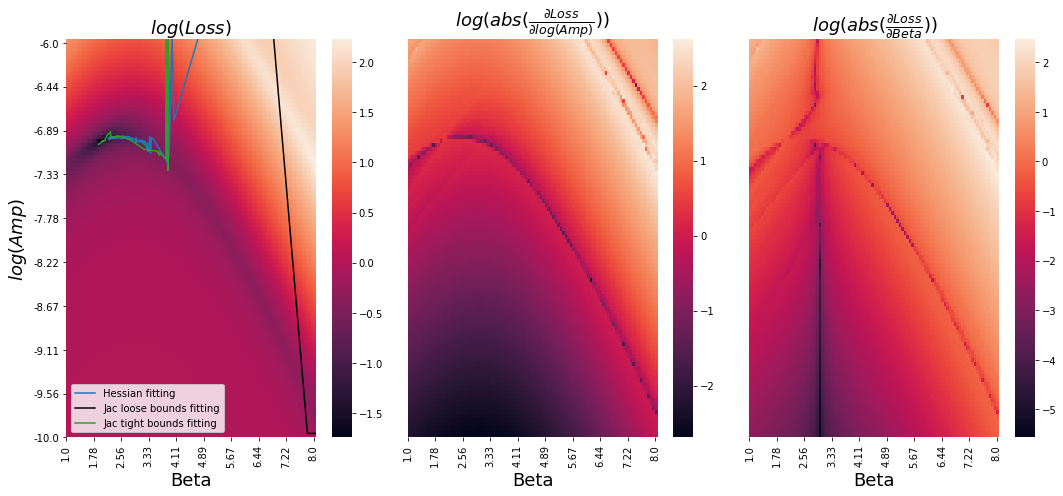

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)
#Fitting
sns.lineplot(ax=ax[0],x=history_hess_x_labels,y=history_hess_y_labels,label='Hessian fitting',color='C0')
#ax[0].lines[0].set_linestyle((0, (1, 4)))
sns.lineplot(ax=ax[0],x=history_jac_loose_x_labels,y=history_jac_loose_y_labels,label='Jac loose bounds fitting',color='black')
#ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
sns.lineplot(ax=ax[0],x=history_jac_tight_x_labels,y=history_jac_tight_y_labels,label='Jac tight bounds fitting',color='C2')
#ax[0].lines[2].set_linestyle((0, (5, 5)))
ax[0].legend(loc='lower left')

#Grad Amp
im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Grad Beta
im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

## Optimize

### with hessian

In [ ]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([-1.,GRF_beta])
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    207.091483    0.137991 -2.910105
   2   -0.856198    4.945717    206.986700    0.183442 -0.644057
   3   -5.868589    4.822722    34.358590    87.559386  42.138639
   4   -5.943401    4.010312    11.876488    28.462279  10.283309
   5   -6.262875    3.900018    4.869780    12.916308  3.930109
   6   -6.794334    4.062581    1.249628    3.842801  1.479443
   7   -7.160458    3.924507    0.387789    0.636191  0.350079
   8   -7.160458    3.924507    0.387789    0.636191  0.350079
   9   -7.160458    3.924507    0.387789    0.636191  0.350079
  10   -7.160458    3.924507    0.387789    0.636191  0.350079
  11   -7.160458    3.924507    0.387789    0.636191  0.350079
  12   -7.207761    3.898954    0.360317    0.164798  0.175580
  13   -7.207761    3.898954    0.360317    0.164798  0.175580
  14   -7.221226    3.884089    0.357859   -0.349431 -0.001718
  15   -7.221226    3.884089    0.357859   -0.349431 -0.001718
  16   -7.221226    3.884089    0.357859   -

KeyboardInterrupt: ignored

In [ ]:
#np.save(Folder+'/Images/history_trust-constr_hess.npy',history)
history_trust_constr_hess=np.load(Folder+'/Images/history_trust-constr_hess.npy',allow_pickle=True)

In [ ]:
history=history_trust_constr_hess

In [ ]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

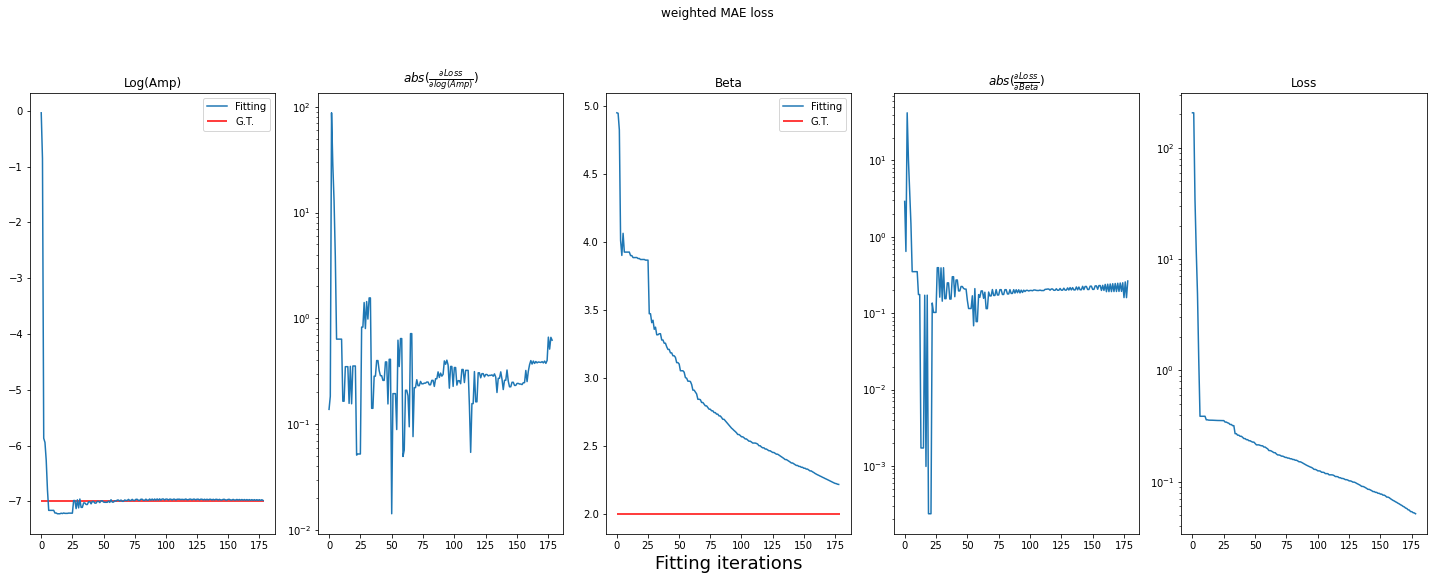

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### only jac

In [ ]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([0.,GRF_beta])
bounds=((-10., -0.), (1., 6.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    207.091483    0.137991 -2.910105
   2   -0.424350    5.356864    207.314332    0.008007  0.407781
   3   -0.431992    5.313520    207.311712    0.003525  0.012143
   4   -0.431992    5.313520    207.311712    0.003525  0.012143
   5   -0.431992    5.313520    207.311712    0.003525  0.012143
   6   -0.436854    5.311473    207.311669    0.003739  0.012419
   7   -0.441763    5.309396    207.311624    0.003970  0.012851
   8   -0.446726    5.307272    207.311575    0.004221  0.013452
   9   -0.451755    5.305082    207.311523    0.004496  0.014247
  10   -0.456862    5.302805    207.311466    0.004799  0.015270
  11   -0.462061    5.300414    207.311402    0.005137  0.016572
  12   -0.467368    5.297880    207.311330    0.005519  0.018223
  13   -0.472807    5.295164    207.311246    0.005959  0.020327
  14   -0.478405    5.292215    207.311148    0.006473  0.023023
  15   -0.484199    5.288968    207.311028    0.007088  0.026501
  16   -0.490237    5.285

In [ ]:
#np.save(Folder+'/Images/history_trust-constr_jac_tight_bounds.npy',history)

#Bounds ((-10.,0.),(1.,10.))
history_trust_constr_jac_loose_bounds=np.load(Folder+'/Images/history_trust-constr_jac_loose_bounds.npy',allow_pickle=True)

#Bounds ((-10.,0.),(1.,6.))
history_trust_constr_jac_tight_bounds=np.load(Folder+'/Images/history_trust-constr_jac_tight_bounds.npy',allow_pickle=True)

In [ ]:
history=history_trust_constr_jac_loose_bounds

In [ ]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

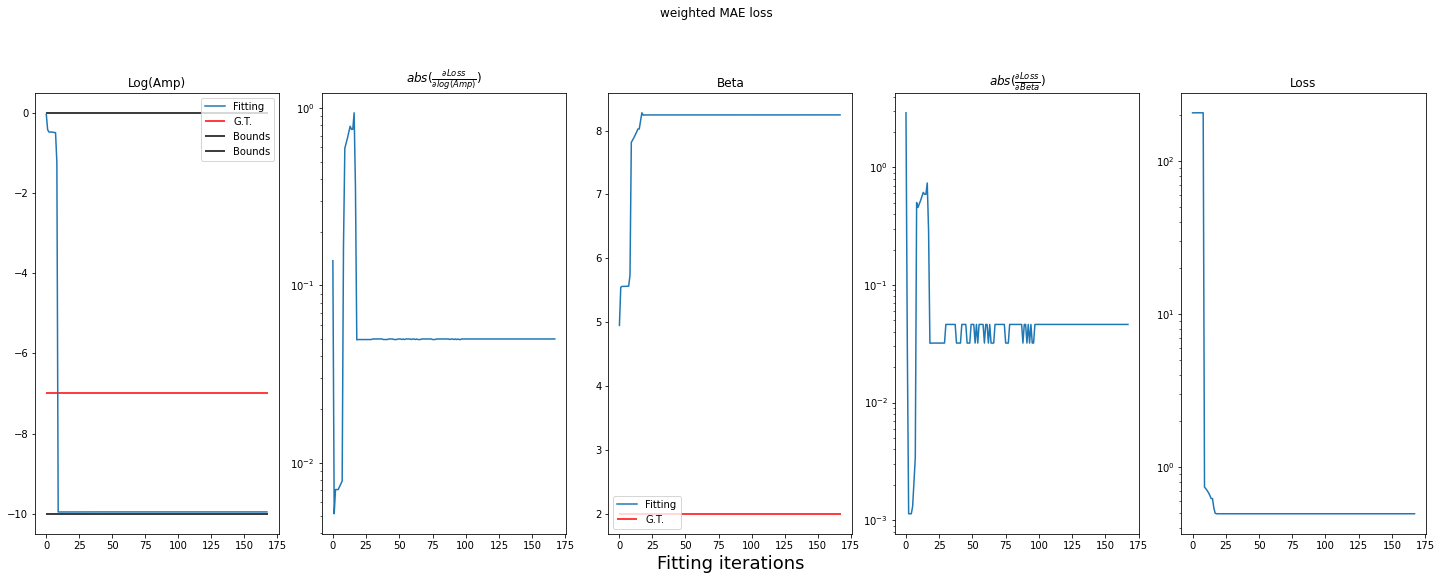

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

## MSE loss function

In [ ]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid_true_spectrum)
GRF_Loss_args=(GRF_seed,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss,*GRF_Loss_args)

In [ ]:
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

Loss: Guess=93898.53, True:0.00
Grad Loss in guess: grad(logA)=124.37, grad(Beta)=-2654.02


Text(0.5, 1.0, 'Log(Abs(Hessian))')

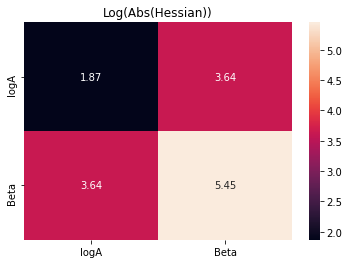

In [ ]:
print('Loss: Guess={:.2f}, True:{:.2f}'.format(loss_func(GRF_init_guess),loss_func([GRF_LogAmp,GRF_beta])))
grad_loss=grad_loss_func(GRF_init_guess)
print('Grad Loss in guess: grad(logA)={:.2f}, grad(Beta)={:.2f}'.format(grad_loss[0],grad_loss[1]))

hess_loss=hess_loss_func(GRF_init_guess)
sns.heatmap(np.log10(np.abs(hess_loss)),xticklabels=['logA','Beta'],yticklabels=['logA','Beta'],annot=True,fmt='.2f')
plt.title('Log(Abs(Hessian))')

## Loss function and grads

In [ ]:
GRF_Amps_array=np.linspace(-7.05,-6.95,100)
GRF_Betas_array=np.linspace(1.5,2.5,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:24<00:00,  5.05s/it]


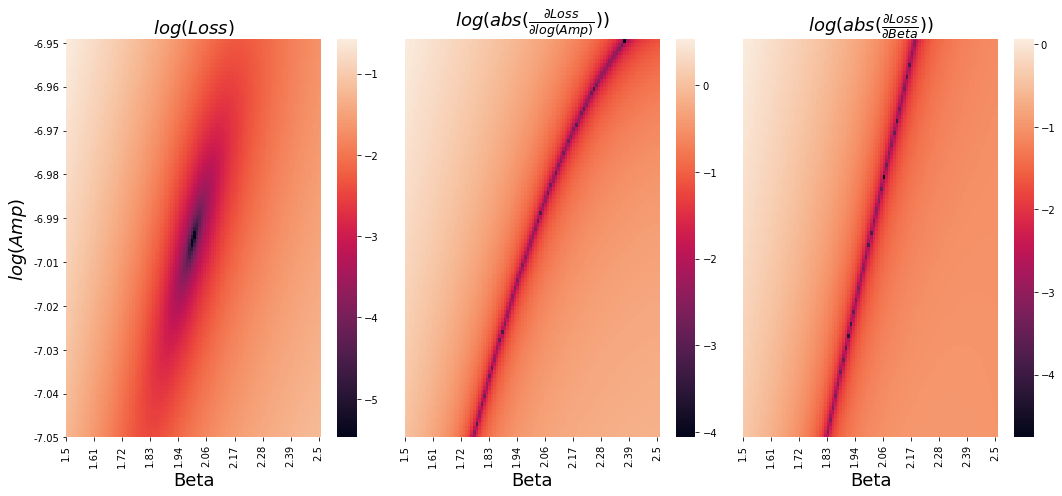

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)


im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

In [ ]:
GRF_Amps_array=np.linspace(-10.,-6.,100)
GRF_Betas_array=np.linspace(1.,8.,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=grad_loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:23<00:00,  5.04s/it]


In [ ]:
history_hess_x_labels,history_hess_y_labels=reindex_history(np.load(Folder+'/Images/MSEhistory_trust-constr_hess.npy',allow_pickle=True))
history_jac_loose_x_labels,history_jac_loose_y_labels=reindex_history(np.load(Folder+'/Images/MSEhistory_trust-constr_jac_loose_bounds.npy',allow_pickle=True))
history_jac_tight_x_labels,history_jac_tight_y_labels=reindex_history(np.load(Folder+'/Images/MSEhistory_trust-constr_jac_tight_bounds.npy',allow_pickle=True))

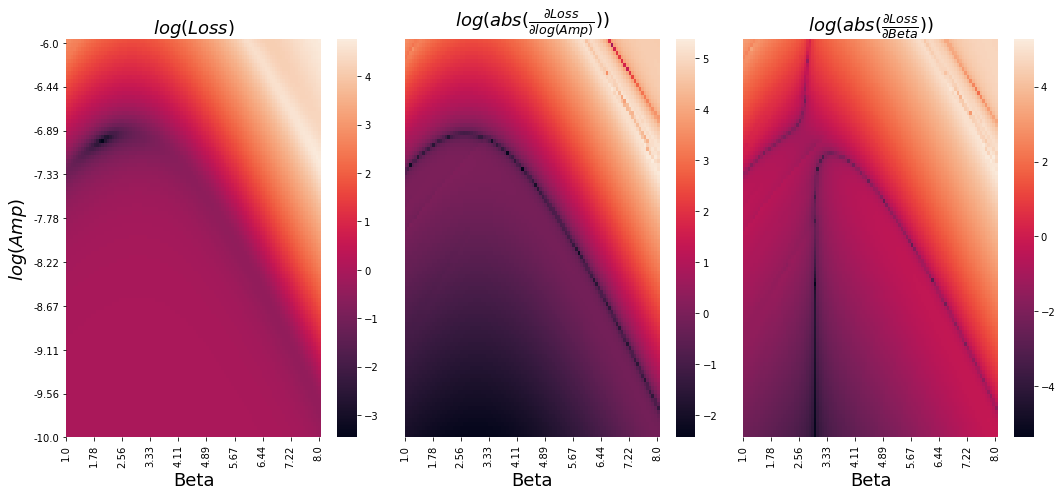

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)
#Fitting
#sns.lineplot(ax=ax[0],x=history_hess_x_labels,y=history_hess_y_labels,label='Hessian fitting',color='C0')
#ax[0].lines[0].set_linestyle((0, (1, 4)))
#sns.lineplot(ax=ax[0],x=history_jac_loose_x_labels,y=history_jac_loose_y_labels,label='Jac loose bounds fitting',color='black')
#ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
#sns.lineplot(ax=ax[0],x=history_jac_tight_x_labels,y=history_jac_tight_y_labels,label='Jac tight bounds fitting',color='C2')
#ax[0].lines[2].set_linestyle((0, (5, 5)))
#ax[0].legend(loc='lower left')

#Grad Amp
im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Grad Beta
im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Possible correlation with physical characteristics of the GRF

$A \propto \frac{\sigma^2_{\delta \psi}}{\sum_{k_x} \sum_{k_y} k^{-\beta}} \propto \frac{\sigma^2_{\delta \alpha}}{\sum_{k_x} \sum_{k_y} k^{-\beta+2}} \propto \frac{\sigma^2_{\delta \kappa}}{\sum_{k_x} \sum_{k_y} k^{-\beta+4}}$

In [ ]:
k_grid,_=PowerBox_jax.get_k_grid_dx(npix,pix_scl)
k_grid[50,50]=np.inf

In [ ]:
variance_stat_sum=np.zeros(100)
deflection_stat_sum=np.zeros(100)
convergence_stat_sum=np.zeros(100)

for i in tqdm(range(100)):
    variance_stat_sum[i]=np.power(k_grid,-GRF_Betas_array[i]).sum()
    deflection_stat_sum[i]=np.power(k_grid,-GRF_Betas_array[i]+2).sum()
    convergence_stat_sum[i]=np.power(k_grid,-GRF_Betas_array[i]+4).sum()

deflection_stat_sum[deflection_stat_sum==np.inf]=np.nan
convergence_stat_sum[convergence_stat_sum==np.inf]=np.nan

Variance_image=np.outer(np.power(10,GRF_Amps_array),variance_stat_sum)
Deflection_image=np.outer(np.power(10,GRF_Amps_array),deflection_stat_sum)
Convergence_image=np.outer(np.power(10,GRF_Amps_array),convergence_stat_sum)

const_Var=np.log10((1e-10*variance_stat_sum[-1])/variance_stat_sum)
const_Def=np.log10((1e-10*deflection_stat_sum[-1])/deflection_stat_sum)
const_Conv=np.log10((1e-10*convergence_stat_sum[-1])/convergence_stat_sum)


const_x_Beta,const_Var_Amp=reindex_history(np.vstack((const_Var,GRF_Betas_array)).T)
const_x_Beta,const_Def_Amp=reindex_history(np.vstack((const_Def,GRF_Betas_array)).T)
const_x_Beta,const_Conv_Amp=reindex_history(np.vstack((const_Conv,GRF_Betas_array)).T)

100%|██████████| 100/100 [00:00<00:00, 506.53it/s]


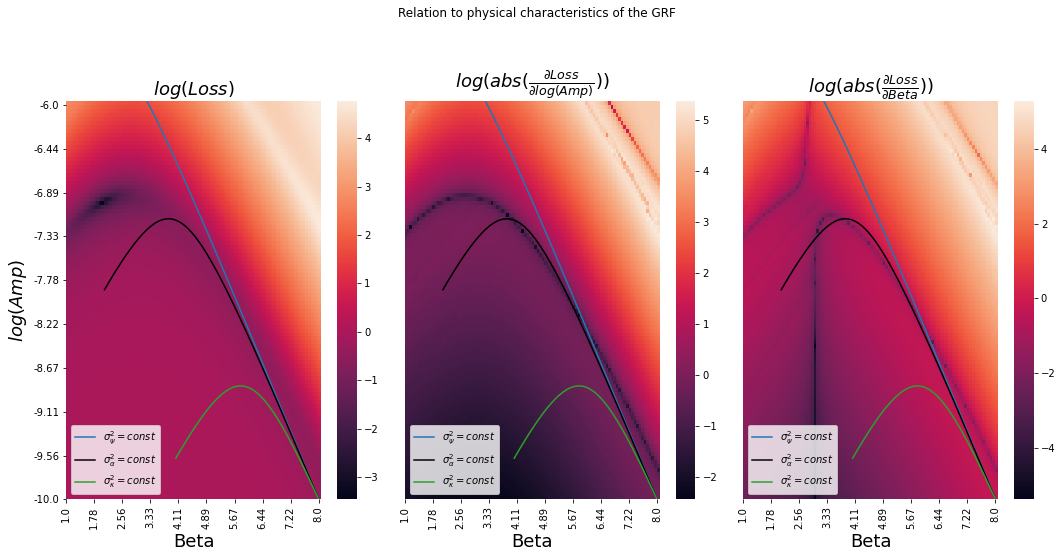

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)


#Grad Amp
im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Grad Beta
im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

  #Const levels
  sns.lineplot(ax=ax[i],x=const_x_Beta,y=const_Var_Amp,label=r'$\sigma^2_{\psi}=const$',color='C0')
  ax[i].lines[0].set_linestyle('solid')
  sns.lineplot(ax=ax[i],x=const_x_Beta,y=const_Def_Amp,label=r'$\sigma^2_{\alpha}=const$',color='black')
  ax[i].lines[1].set_linestyle('solid')
  sns.lineplot(ax=ax[i],x=const_x_Beta,y=const_Conv_Amp,label=r'$\sigma^2_{\kappa}=const$',color='C2')
  ax[i].lines[2].set_linestyle('solid')
  ax[i].legend(loc='lower left')
  
 
ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()
fig.suptitle('Relation to physical characteristics of the GRF',y=1.1)

plt.show()

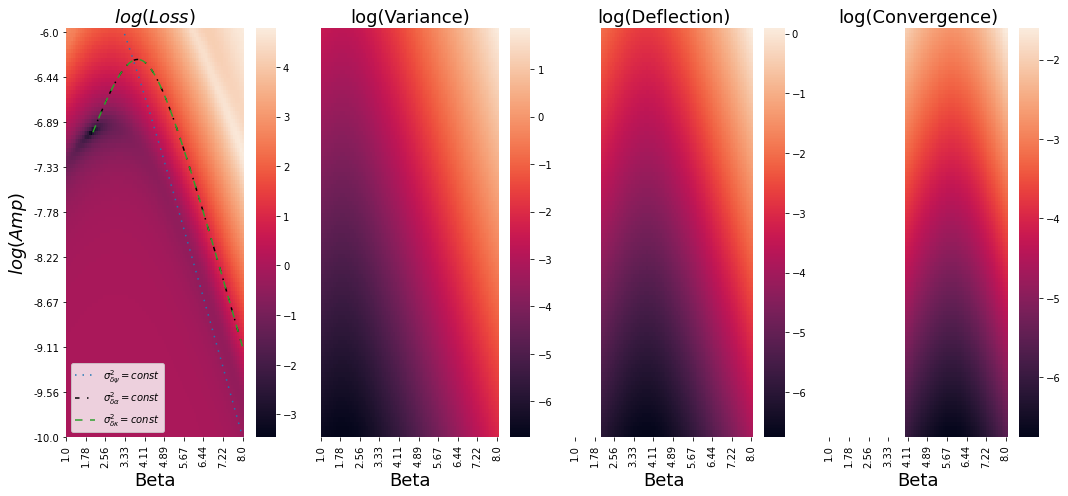

In [ ]:
fig,ax=plt.subplots(1,4,figsize=(15,7))

y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)




#Loss
im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Const levels
sns.lineplot(ax=ax[0],x=const_x_Beta,y=const_Var_Amp,label=r'$\sigma^2_{\delta \psi}=const$',color='C0')
ax[0].lines[0].set_linestyle((0, (1, 4)))
sns.lineplot(ax=ax[0],x=const_x_Beta,y=const_Def_Amp,label=r'$\sigma^2_{\delta \alpha}=const$',color='black')
ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
sns.lineplot(ax=ax[0],x=const_x_Beta,y=const_Conv_Amp,label=r'$\sigma^2_{\delta \kappa}=const$',color='C2')
ax[0].lines[2].set_linestyle((0, (5, 5)))
ax[0].legend(loc='lower left')

#Variance
im=sns.heatmap(ax=ax[1],data=np.log10(Variance_image),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Deflection
im=sns.heatmap(ax=ax[2],data=np.log10(Deflection_image),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

#Convergence
im=sns.heatmap(ax=ax[3],data=np.log10(Convergence_image),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

fig_names=[r'$log(Loss)$','log(Variance)','log(Deflection)','log(Convergence)']
for i in range(4):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

## Optimize

### with hessian

In [ ]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([-1.,GRF_beta])
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   2   -0.856200    4.945830    93802.966953    169.763134 -565.016849
   3   -5.868603    4.823393    2060.714368    10809.194234  5231.891315
   4   -5.963693    4.624140    765.942570    3926.522233  1850.125030
   5   -6.118314    4.552678    295.923386    1480.874943  693.268645
   6   -6.296659    4.512743    109.559732    556.830098  256.625525
   7   -6.493893    4.507251    39.090181    205.817236  94.455083
   8   -6.688996    4.499141    13.265328    74.782952  34.160232
   9   -6.846187    4.427419    4.337609    26.852622  12.029882
  10   -6.993091    4.361358    1.378231    9.337655  4.160843
  11   -7.121073    4.303814    0.494322    3.024544  1.398408
  12   -7.217084    4.258816    0.282365    0.821834  0.455768
  13   -7.268478    4.229778    0.250500    0.127337  0.163385
  14   -7.268478    4.229778    0.250500    0.127337  0.163385
  15   -7.268478    4.229778    0.250500    0.127337  0.16338

In [ ]:
np.save(Folder+'/Images/MSEhistory_trust-constr_hess.npy',history)
history_trust_constr_hess=np.load(Folder+'/Images/MSEhistory_trust-constr_hess.npy',allow_pickle=True)

In [ ]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

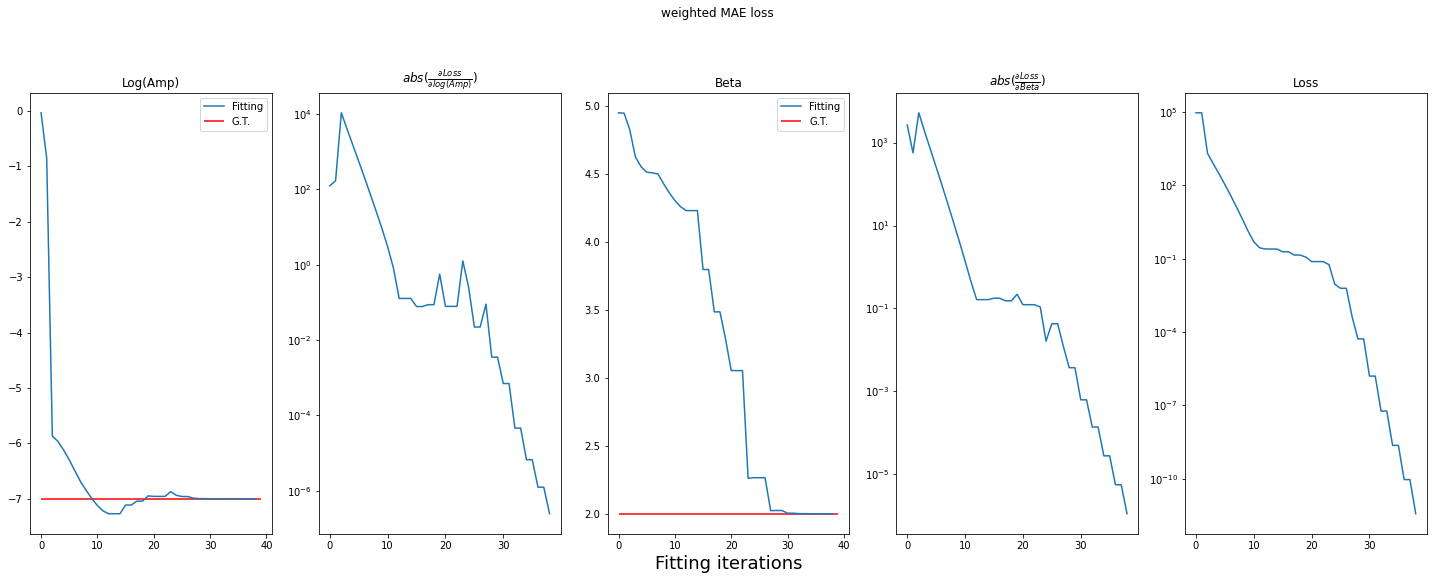

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### only jacobian

In [ ]:
Nfeval = 1
history=np.zeros((0,2))
init_guess=np.array([0.,GRF_beta])
bounds=((-10., -0.), (1., 6.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   1   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   2   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   3   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   4   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   5   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   6   -0.035741    4.949092    93898.525070    124.367351 -2654.024849
   7   -0.034966    4.965073    93898.349367    108.099959  2564.072969
   8   -0.034121    4.950125    93896.132090    120.124269 -2359.932024
   9   -0.044675    4.957270    93886.631516    100.305468  75.198587
  10   -0.095631    4.957070    93881.564259    98.091506  57.651556
  11   -1.323397    4.953307    93670.354084    521.297661  2346.429224
  12   -8.834048    4.924309    0.917340   -0.183921 -0.091864
  13   -8.830379    4.924320    0.916661   -0.185377 -0.092591
  14   -8.826692    4.924331    0.915974   -0.186850 -0.093327
  15   -8.822989    4.92

In [ ]:
np.save(Folder+'/Images/MSEhistory_trust-constr_jac_tight_bounds.npy',history)

#Bounds ((-10.,0.),(1.,10.))
#history_trust_constr_jac_loose_bounds=np.load(Folder+'/Images/MSEhistory_trust-constr_jac_loose_bounds.npy',allow_pickle=True)

#Bounds ((-10.,0.),(1.,6.))
#history_trust_constr_jac_tight_bounds=np.load(Folder+'/Images/MSEhistory_trust-constr_jac_tight_bounds.npy',allow_pickle=True)

In [ ]:
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([grad_loss_func(x) for x in history])

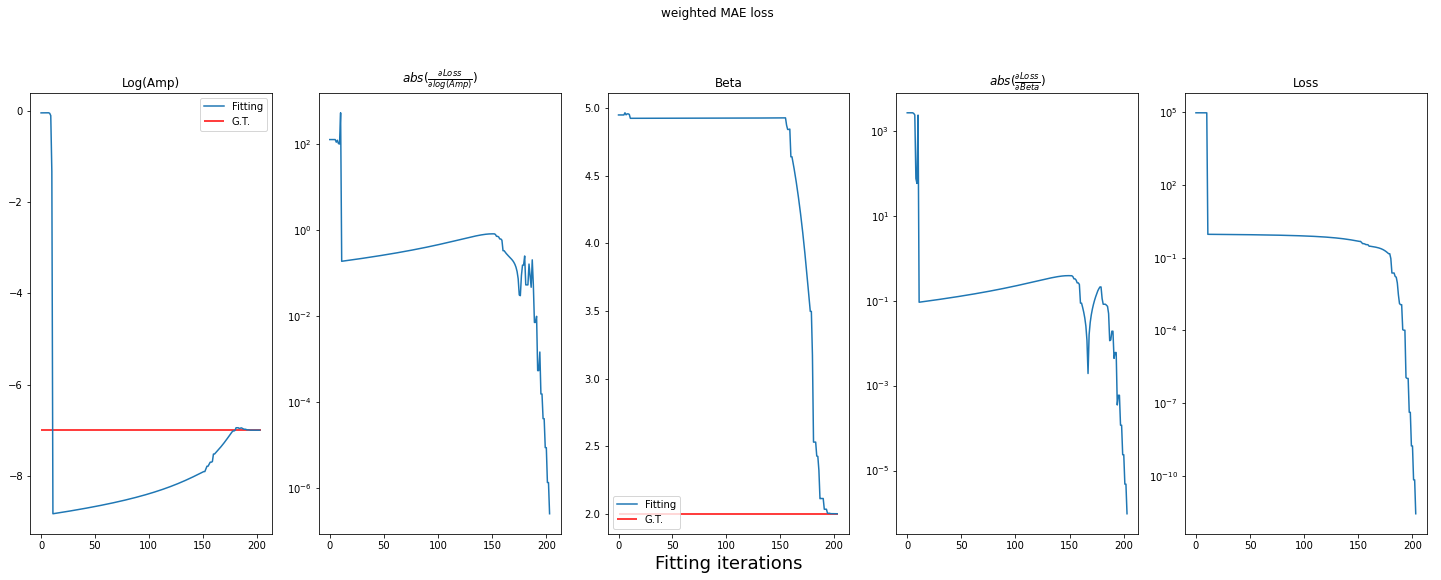

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

# GRF unknown phase fitting

## Phase averaging GRF Loss

### For loop requirements

In [107]:
#Random phases of GRF in Fourier space
def get_phase_realisation(npix,seed):
  "A random array which has Gaussian magnitudes and Hermitian symmetry"
  key=jax.random.PRNGKey(seed)
  #uneven number
  n=npix + 1 if (npix%2==0) else npix
  #2d grid
  size=[n]*2

  magnitude=jax.random.normal(key, shape=size)
  phase=2 * jnp.pi * jax.random.uniform(key,shape=size)

  #Make hermitian (why?)
  magnitude=(magnitude+magnitude[::-1,::-1])/jnp.sqrt(2)
  phase=(phase-phase[::-1,::-1])/2 + jnp.pi

  phase_realisation=magnitude * (jnp.cos(phase) + 1j * jnp.sin(phase))

  if (npix%2==0):
    #why?
    phase_realisation=phase_realisation[:-1,:-1]

  return phase_realisation

In [153]:
#The very jaxified GRF. params=(Amplitude,Power_slope)
def get_jaxified_GRF(params,seed,npix,pix_scl):

  logA,beta=params
  A=jnp.power(10.,logA)

  k_grid,dx=PowerBox_jax.get_k_grid_dx(npix,pix_scl)
  k_grid[npix//2,npix//2]=1
  mask_center=np.ones_like(k_grid)
  mask_center[npix//2,npix//2]=0


  sqrt_power_array=jnp.sqrt(A)*jnp.power(k_grid,-beta/2.)*mask_center
  phase_realisation=get_phase_realisation(npix,seed)

  Fourier_image=sqrt_power_array*phase_realisation

  Config_image=(npix**2)*jnp.fft.ifftshift(jnp.fft.ifftn(Fourier_image))

  Config_image=PowerBox_jax._adjust_phase(Config_image,npix, pix_scl)

  return jnp.real(Config_image)

def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

In [151]:
def jax_map(f, xs):
  scan_func = lambda _,x: (1,f(x))
  ys=jax.lax.scan(scan_func,0,xs)[1]
  return ys

In [154]:
def test(GRF_params,GRF_seeds,npix,pix_scl):
  func=lambda GRF_seed: get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)
  GRFs=jax_map(func,GRF_seeds)
  return jnp.mean(GRFs)

test_pure=purify_function(test,GRF_seeds,npix,pix_scl)

In [155]:
test_pure(GRF_params)

DeviceArray(-1.28369537e-20, dtype=float64)

In [156]:
jax.grad(test_pure)(GRF_params)

DeviceArray([ 1.72057354e-20, -9.66918830e-22], dtype=float64)

### Fitting with phase averaging

In [195]:
def GRF_Loss_phase_averaging(GRF_params,GRF_seeds,jax_map,unperturbed_image,
             get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
             compute_radial_spectrum_pure,Spectra_Loss_pure):

  #Mapping GRF generator over seeds
  get_GRF=lambda GRF_seed: get_jaxified_GRF_pure(GRF_params,GRF_seed)
  GRFs=jax_map(get_GRF,GRF_seeds)

  #Mapping image generator over seeds
  simulated_images=jax_map(simulate_perturbed_image_pure,GRFs)

  resids=simulated_images-unperturbed_image
  #Map over residuals for each seed
  resid_spectra=jax_map(compute_radial_spectrum_pure,resids)

  Spectra_Losses=jax_map(Spectra_Loss_pure,resid_spectra)

  return jnp.mean(Spectra_Losses)

In [196]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)

Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,jax_map,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

In [199]:
Loss=(GRF_Loss_pure)(GRF_params)
Grad_Loss=jax.grad(GRF_Loss_pure)(GRF_params)

In [200]:
Loss

DeviceArray(0.23954485, dtype=float64)

In [201]:
Grad_Loss

DeviceArray([-0.11464667, -0.07556207], dtype=float64)

### Fitting with kwargs fitting

In [319]:
def GRF_Loss_image_fitting(GRF_params,GRF_seed,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure):

  GRF=get_jaxified_GRF_pure(GRF_params,GRF_seed)

  simulated_image=simulate_perturbed_image_pure(GRF)

  model_loss_function_pure=purify_function(model_loss_function,simulated_image,parameters,simulate_smooth_image_pure)
  model_loss_grad=jax.grad(model_loss_function_pure)

  args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
  unperturbed_image=simulate_smooth_image_pure(parameters.args2kwargs(args_fit))


  resid=simulated_image-unperturbed_image
  #Map over residuals for each seed
  resid_spectrum=compute_radial_spectrum_pure(resid)

  return Spectra_Loss_pure(resid_spectrum)

args_guess=parameters.kwargs2args(kwargs_data)
learning_rate=1
max_iter=100
GRF_Loss_image_fitting_args=(GRF_seed,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

In [320]:
GRF_Loss_image_fitting_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)

In [321]:
GRF_Loss_image_fitting_pure(GRF_params)

DeviceArray(103031.14678613, dtype=float64)

In [322]:
jax.grad(GRF_Loss_image_fitting_pure)(GRF_params)

DeviceArray([14042.90651257, -3822.76900632], dtype=float64)

In [285]:
def gradient_descent(gradient_function,initial_guess,max_iter,learning_rate):

  step_function= lambda _,X: X-learning_rate*gradient_function(X)

  return jax.lax.fori_loop(0,max_iter,step_function,initial_guess)

In [286]:
simulate_smooth_image??

In [298]:
parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)
def smooth_image_from_args(args,parameters,smooth_lens_image):
    kwargs=parameters.args2kwargs(args)
    return smooth_lens_image.model(**kwargs)

def lens_model_loss_function(args_model,true_image,smooth_image_from_args):
    model_image=smooth_image_from_args(args_model,parameters,smooth_lens_image)
    return jnp.mean(jnp.power(true_image-model_image,2))

lens_model_loss_function_pure=purify_function(lens_model_loss_function,perturbed_image,smooth_image_from_args)
lens_model_loss_function_grad=jax.grad(lens_model_loss_function_pure)

In [307]:
def test_func(perturbed_image):

  lens_model_loss_function_pure=purify_function(lens_model_loss_function,perturbed_image,smooth_image_from_args)
  lens_model_loss_function_grad=jax.grad(lens_model_loss_function_pure)

  args_fit=gradient_descent(lens_model_loss_function_grad,args_data,100,1)
  return jnp.mean(args_fit)

In [308]:
args_fit=test_func(perturbed_image)
args_fit

DeviceArray(1.06525433, dtype=float64)

In [309]:
image_grad=jax.grad(test_func)(perturbed_image)
image_grad

DeviceArray([[ 2.59096499e-06,  2.58111101e-06,  2.56222307e-06, ...,
              -8.61087507e-06, -7.92913190e-06, -7.43262708e-06],
             [ 2.75437164e-06,  2.74746110e-06,  2.73234056e-06, ...,
              -8.69403412e-06, -7.98733500e-06, -7.47313434e-06],
             [ 2.98069676e-06,  2.97804598e-06,  2.96840119e-06, ...,
              -8.78917836e-06, -8.04905331e-06, -7.51119510e-06],
             ...,
             [ 1.25822568e-07, -5.55769577e-08, -3.11478599e-07, ...,
               9.77560269e-06,  9.66589213e-06,  9.57398842e-06],
             [-1.54353252e-07, -3.38898415e-07, -5.98558393e-07, ...,
               8.94754429e-06,  8.86587527e-06,  8.79516182e-06],
             [-3.53569546e-07, -5.39963603e-07, -8.01745397e-07, ...,
               8.35417245e-06,  8.29189050e-06,  8.23586507e-06]],            dtype=float64)

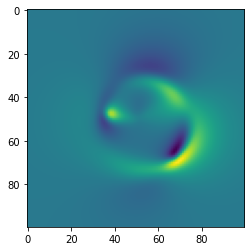

In [310]:
plt.imshow(image_grad)

In [300]:
lens_model_loss_function_grad(args_data)

DeviceArray([ 6.81316887e-04, -1.41564855e-04, -1.82857258e-04,
             -1.92534138e-04,  5.46093013e-04,  3.84206441e-04,
              5.47206705e-04,  1.31644039e-05, -1.44542959e-05,
              1.85214443e-04,  9.72754374e-05, -3.12118343e-05,
              4.04593418e-04, -4.09870720e-04], dtype=float64)

In [304]:
args_fit-args_data

DeviceArray([-0.01160592, -0.00032954, -0.00113101,  0.00300114,
             -0.00878816, -0.00072539, -0.00276271, -0.00088603,
              0.00280663, -0.01477706, -0.00750633,  0.00506102,
             -0.00503509,  0.00623905], dtype=float64)

In [292]:
args_data=parameters.kwargs2args(kwargs_data)

In [293]:
args_data

DeviceArray([ 1.6 ,  0.15, -0.04,  0.  ,  0.  , -0.01,  0.03, 10.  ,
              1.2 ,  1.5 ,  0.07, -0.1 ,  0.4 ,  0.15], dtype=float64)

In [ ]:
def minimize_function(function,grad_func,initial_guess,args,max_iter,learning_rate,jax_map):

    history=np.zeros(learning_rate)
    history[0]=initial_guess

    def step(arg,max_iter,learning_rate):
      i,X=arg
      new_X=X-learning_rate*grad_func(X)
      new_arg=(i+1,new_X)

      Bool_end=((i+1)>=max_iter)

      return_answer=lambda _,X: return new_X
      continue_cycle=lambda i,X: return step(new_arg,max_iter,learning_rate)

      return jax.lax.cond(Bool_end,return_answer,continue_cycle,new_arg)

In [238]:
def grad_descent(arg,grad_func,max_iter,learning_rate):
      i,X=arg
      new_X=X-learning_rate*grad_func(X)

      Bool_end=((i+1)>=max_iter)

      #Return optimization argument
      #return_answer=lambda _,new_X: new_X
      #Recursively continue descent
      #continue_cycle=lambda i,new_X: grad_descent((i+1,new_X),grad_func,max_iter,learning_rate)
      continue_cycle=lambda new_arg: grad_descent(new_arg,grad_func,max_iter,learning_rate)
      return_answer=lambda arg: arg

      return jax.lax.cond(Bool_end,return_answer,continue_cycle,(i+1,new_X))

#### Gradient descent

In [271]:
def test_func(model,data):
  return jnp.abs(model-data)

learning_rate=0.01
max_iter=100


def test(data):

  test_func_pure=lambda model: test_func(model,10.)
  test_func_grad=jax.grad(test_func_pure)

  step= lambda i,X: X-learning_rate*test_func_grad(X)

  model=jax.lax.fori_loop(0,max_iter,step,data**2)
  return model

In [275]:
def gradient_descent(gradient_function,initial_guess,max_iter,learning_rate):

  step_function= lambda _,X: X-learning_rate*gradient_function(X)

  return jax.lax.fori_loop(0,max_iter,step_function,initial_guess)

In [276]:
test_func_pure=lambda model: test_func(model,10.)
test_func_grad=jax.grad(test_func_pure)

In [280]:
gradient_descent_pure=lambda initial_guess: gradient_descent(test_func_grad,initial_guess,100,0.1)
jax.grad(gradient_descent_pure)(0.)

DeviceArray(1., dtype=float64)

In [273]:
jax.grad(test)(2.)

DeviceArray(4., dtype=float64)

In [274]:
jax.grad(test)(3.)

DeviceArray(6., dtype=float64)

In [269]:
test(2.)

DeviceArray(3., dtype=float64)

In [244]:


def step(i,X):
  return X-learning_rate*test_func_grad(X)

X=jax.lax.fori_loop(0,max_iter,step,0.)

In [245]:
X

DeviceArray(10., dtype=float64)

In [232]:
test_func_grad(5.)

DeviceArray(-1., dtype=float64)

In [239]:
init_guess=(0,0.)
grad_descent(init_guess,test_func_grad,10,0.1)

RecursionError: ignored

### Else

In [130]:
#g = jax.jit(lambda _,GRF_seed: (1,np.ones((npix,npix))*GRF_seed))
g = lambda _,GRF_seed: (1,get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl))
GRFs=(jax.lax.scan(g,0,GRF_seeds)[1])

In [137]:
def test(GRF_params,GRF_seeds,npix,pix_scl):
  g = lambda _,GRF_seed: (1,get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl))
  GRFs=(jax.lax.scan(g,0,GRF_seeds)[1])
  return jnp.mean(GRFs)

test_pure=purify_function(test,GRF_seeds,npix,pix_scl)

In [144]:
def jax_map(f, xs):
  scan_func = lambda _,x: (1,f(x))
  ys=jax.lax.scan(scan_func,0,xs)[1]
  return ys

In [145]:
func=lambda GRF_seed: get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)
GRFs=jax_map(func,GRF_seeds)

In [148]:
def test(GRF_params,GRF_seeds,npix,pix_scl):
  func=lambda GRF_seed: get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)
  GRFs=jax_map(func,GRF_seeds)
  return jnp.mean(GRFs)

test_pure=purify_function(test,GRF_seeds,npix,pix_scl)

In [149]:
test_pure(GRF_params)

DeviceArray(-1.28369537e-20, dtype=float64)

In [150]:
jax.grad(test_pure)(GRF_params)

DeviceArray([ 1.72057354e-20, -9.66918830e-22], dtype=float64)

In [138]:
test_pure(GRF_params)

DeviceArray(-1.28369537e-20, dtype=float64)

In [141]:
jax.grad(test_pure)(GRF_params)

DeviceArray([ 1.72057354e-20, -9.66918830e-22], dtype=float64)

In [ ]:
def GRF_Loss_phase_averaging(GRF_params,GRF_seeds,unperturbed_image,
             get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
             compute_radial_spectrum_pure,Spectra_Loss_pure):


  GRFs=get_jaxified_GRF_pure(GRF_params,GRF_seed)

  simulated_image=simulate_perturbed_image_pure(GRF)

  resid=simulated_image-unperturbed_image
  resid_spectrum=compute_radial_spectrum_pure(resid)

  return Spectra_Loss_pure(resid_spectrum)

In [136]:
test(GRF_params,GRF_seeds,npix,pix_scl)

DeviceArray(-2.07125983e-19, dtype=float64)

In [132]:
GRFs.shape

(8, 100, 100)

In [127]:
test(GRF_params,GRF_seed)

DeviceArray([[ 3.25806937e-04, -1.39600163e-02, -2.37375768e-02, ...,
              -8.88541266e-03, -3.23081929e-03, -2.46492310e-03],
             [-7.24474457e-03, -1.77732719e-02, -2.79357125e-02, ...,
               1.05281659e-03, -4.40623246e-03, -2.26561027e-04],
             [-1.01756208e-02, -1.89674044e-02, -4.25634981e-02, ...,
              -1.32873739e-03, -6.52506532e-03,  5.27138495e-03],
             ...,
             [-9.65185178e-03, -6.77607686e-03, -1.10149004e-02, ...,
               1.62030230e-05, -7.61569564e-03, -1.78757703e-02],
             [-1.67147186e-03, -5.47283177e-03, -1.16820204e-02, ...,
               1.46123272e-02, -1.07998702e-02, -1.30477015e-02],
             [ 6.94097951e-03,  4.94321425e-03, -1.39605537e-02, ...,
               1.31260745e-02,  8.41794504e-03,  8.53962036e-03]],            dtype=float64)

In [128]:
vv = lambda GRF_seed, GRF_params: test(GRF_params,GRF_seed)
mv = jax.vmap(vv, (0, None), 0)
matrix=np.outer([5,6],GRF_seed)
mv(matrix,GRF_params)

TypeError: ignored

In [124]:
jax.grad(jax.jit(lambda GRF_params: np.std(test(GRF_params))))(GRF_params)

DeviceArray([0.01728465, 0.00479345], dtype=float64)

In [ ]:
key=random.PRNGKey(0)
jax.random.normal()

In [100]:
jnp.random.normal(size=(1,2))

AttributeError: ignored

In [99]:
@jax.partial(jax.jit,static_argnums=(1,))
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

In [96]:
vv = lambda x, y: print(x,y)
mv = jax.vmap(vv, (0, None), 0)
mm = jax.vmap(mv, (None, 1), 1)

In [97]:
vv(GRF_seed,GRF_params)

1 [-7.  2.]


In [89]:
get_jaxified_GRF_pure??

In [98]:
matrix=np.outer([5,6],GRF_seed)
mv(matrix,GRF_params)

Traced<ShapedArray(int64[1])>with<BatchTrace(level=1/0)>
  with val = array([[5],
                    [6]])
       batch_dim = 0 [-7.  2.]


In [83]:
arr1=1
matrix=np.outer([5,6],arr1)
arr2=np.array([2,3,4])
vv(arr1,arr2)

array([2, 3, 4])

In [84]:
mv(matrix,arr2)

DeviceArray([[10, 15, 20],
             [12, 18, 24]], dtype=int64)

In [ ]:
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)

In [64]:
def get_jaxified_GRF_traced(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

In [59]:
GRF_params=jnp.array([GRF_LogAmp,GRF_beta])
get_jaxified_GRF_pure(GRF_params,GRF_seed)

DeviceArray([[-0.01243255, -0.00829889,  0.00402387, ..., -0.00904885,
              -0.00604214, -0.00302176],
             [-0.00226499, -0.01453809, -0.0219767 , ...,  0.01113688,
               0.00434794,  0.00886271],
             [ 0.00602436, -0.01029537, -0.01696046, ...,  0.01601606,
               0.01204917,  0.00664493],
             ...,
             [ 0.01468725,  0.00566183,  0.01739841, ..., -0.0066037 ,
               0.00138568,  0.01062642],
             [-0.00426157, -0.00196087, -0.01263381, ..., -0.00767667,
              -0.00317466, -0.00206083],
             [-0.01814698,  0.00783441, -0.00736378, ..., -0.01183791,
              -0.02245846, -0.02427405]], dtype=float64)

In [63]:
get_jaxified_GRF_pure??

In [69]:
#g = jax.jit(lambda _,GRF_seed: (1,np.ones((npix,npix))*GRF_seed))
g = lambda _,GRF_seed: get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)
GRFs=(jax.lax.scan(g,0,GRF_seeds)[1])

In [70]:
GRFs=(jax.lax.scan(g,0,GRF_seeds)[1])

ConcretizationTypeError: ignored

In [55]:
GRFs

DeviceArray([[[2., 2., 2., ..., 2., 2., 2.],
              [2., 2., 2., ..., 2., 2., 2.],
              [2., 2., 2., ..., 2., 2., 2.],
              ...,
              [2., 2., 2., ..., 2., 2., 2.],
              [2., 2., 2., ..., 2., 2., 2.],
              [2., 2., 2., ..., 2., 2., 2.]],

             [[3., 3., 3., ..., 3., 3., 3.],
              [3., 3., 3., ..., 3., 3., 3.],
              [3., 3., 3., ..., 3., 3., 3.],
              ...,
              [3., 3., 3., ..., 3., 3., 3.],
              [3., 3., 3., ..., 3., 3., 3.],
              [3., 3., 3., ..., 3., 3., 3.]],

             [[4., 4., 4., ..., 4., 4., 4.],
              [4., 4., 4., ..., 4., 4., 4.],
              [4., 4., 4., ..., 4., 4., 4.],
              ...,
              [4., 4., 4., ..., 4., 4., 4.],
              [4., 4., 4., ..., 4., 4., 4.],
              [4., 4., 4., ..., 4., 4., 4.]],

             ...,

             [[7., 7., 7., ..., 7., 7., 7.],
              [7., 7., 7., ..., 7., 7., 7.],
              [7.,

In [22]:
GRF_seeds=np.arange(2,10)

In [26]:
GRF_seeds

array([2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
def map(f, xs):
    return np.stack([f(x) for x in xs])

In [36]:
map(g,GRF_seeds)

array([[[-0.00570171, -0.00129161,  0.0058245 , ..., -0.00757102,
         -0.00243726, -0.01649447],
        [ 0.00493164, -0.00220677, -0.00262641, ..., -0.01041471,
         -0.0095766 , -0.01066423],
        [-0.00321968, -0.01664846, -0.00271096, ..., -0.0238819 ,
         -0.00081087, -0.00673764],
        ...,
        [-0.00682896,  0.00358378,  0.00185109, ..., -0.00034693,
         -0.0172854 , -0.01211973],
        [ 0.00313957,  0.00894859,  0.00696749, ...,  0.00331316,
         -0.01668601, -0.00939343],
        [-0.01528318,  0.00801151,  0.00499301, ...,  0.00171082,
          0.00492917, -0.01536378]],

       [[ 0.00245054, -0.00181478,  0.00855211, ..., -0.00014682,
          0.00316356,  0.0037077 ],
        [-0.01105917,  0.00272392,  0.00126246, ..., -0.00935565,
          0.00261621, -0.00807424],
        [ 0.00189058,  0.01246546, -0.00043618, ..., -0.00888243,
         -0.00943269, -0.01652462],
        ...,
        [ 0.00740169,  0.00177444,  0.00654389, ...,  

In [33]:
jax.lax.scan(test, 0, tuple([1,2,3]))[1]

ValueError: ignored

In [17]:
q=lambda GRF_seed: get_jaxified_GRF_pure([GRF_LogAmp,GRF_beta],GRF_seed)

In [18]:
q_mapped=jax.vmap(get_jaxified_GRF_pure,in_axes=(0,None,),out_axes=(None,))

In [20]:
q_mapped([2,3])

ValueError: ignored

In [16]:
unperturbed_image.shape

(100, 100)

In [ ]:

def GRF_Loss_phase_averaging(GRF_params,GRF_seed_array,unperturbed_image,
             get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
             compute_radial_spectrum_pure,Spectra_Loss_pure):

  (npix,_)=unperturbed_image.shape
  phase_number=len(GRF_seed_array)
  GRFs=jnp.ones((phase_number,npix,npix))

  

  GRF=get_jaxified_GRF_pure(GRF_params,GRF_seed)

  simulated_image=simulate_perturbed_image_pure(GRF)

  resid=simulated_image-unperturbed_image
  resid_spectrum=compute_radial_spectrum_pure(resid)

  return Spectra_Loss_pure(resid_spectrum)

## MAE loss function

In [15]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)